In [1]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas
import math
import numpy as np
import lmfit
import os
from uncertainties import ufloat
import array_to_latex as atl

In [2]:
plt.rc ('font', size = 15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

In [3]:
def pos(x):
    for i in range(len(data[0])):
        if data[0,i]>=x:
            return i
            break

FitFunktionen

In [4]:
def gaus1fit(von,bis,path,yscale,m=1,mmin=0,mmax=2,s=0.2,smax=1000,scale=1e-9,override=False): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus = lmfit.models.GaussianModel()  
    pars_gaus=model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["center"].set(value=m,min=mmin,max=mmax)
        pars_gaus["sigma"].set(value=1,min=0)
        pars_gaus["amplitude"].set(value=1,min=0)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],weights=1/data[2,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],yscale*data[1,vonarr:bisarr],yerr=yscale*data[2,vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),yscale*out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())


    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))]),out_gaus




def gaus2fit(von,bis,path,yscale,override=False,m1=1,s1=1,scale1=1,m2=1,s2=1,scale2=1,m1min=1,m1max=1,m2min=1,m2max=1): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus=lmfit.models.GaussianModel(prefix="g1_")+lmfit.models.GaussianModel(prefix="g2_")

    def guess(data,x):
        params_g1=lmfit.models.GaussianModel(prefix="g1_").guess(data,x)
        params=model_gaus.make_params()
        for i in params_g1:
            params[i]=params_g1[i]
                    
        params["g2_center"].value=params.get("g1_center").value-1
        params["g2_sigma"].value=params.get("g1_sigma").value*0.5
        params["g2_amplitude"].value=params.get("g1_amplitude").value*0.3
        return params

    model_gaus.guess=guess
    pars_gaus = model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["g1_center"].set(value=m1,min=m1min,max=m1max)
        pars_gaus["g1_sigma"].set(value=s1)
        pars_gaus["g1_amplitude"].set(value=scale1)
        pars_gaus["g2_center"].set(value=m2,min=m2min,max=m2max)
        pars_gaus["g2_sigma"].set(value=s2)
        pars_gaus["g2_amplitude"].set(value=scale2)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],weights=1/data[2,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],yscale*data[1,vonarr:bisarr],yerr=yscale*data[2,vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),yscale*out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())

    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))]),out_gaus

Daten einlesen und Standartfehler as Fehler der Counts festlegen

<ErrorbarContainer object of 3 artists>

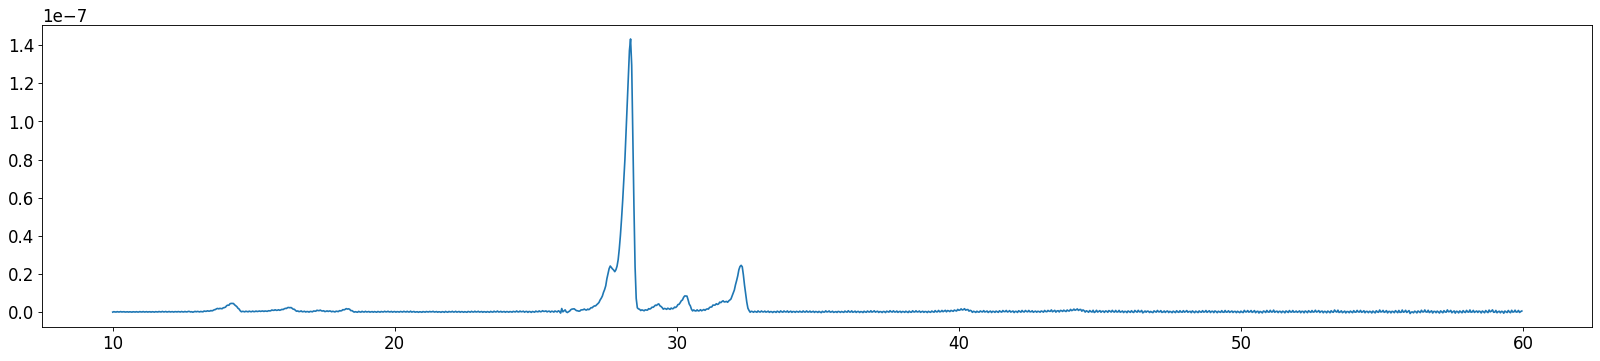

In [5]:
with open('Data/probe.csv', mode='r') as tf:
        dataex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        data = np.zeros((3,len(dataex[3])))
        data[0],data[1] = dataex[3],dataex[4]

with open('Data/restgas.csv', mode='r') as tf:
        datarestex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        datarest = np.zeros((3,len(datarestex[3])))
        datarest[0],datarest[1] = datarestex[3],datarestex[4]



#data
err = list(np.zeros(len(data[1])))
for i in range(len(err)):
    err[i] = ufloat(data[1,i],float(abs(data[1,i])*0.05))

#est
errrest = list(np.zeros(len(datarest[1])))
for i in range(len(errrest)):
    errrest[i] = ufloat(datarest[1,i],float(abs(datarest[1,i])*0.05))

for i in range(len(err)):
        err[i] = err[i]-errrest[i]

for i in range(len(data[1])):
    err[i] = err[i]*data[0,i]/28

for i in range(len(err)):
    data[1,i]=err[i].n
    data[2,i]=err[i].s





v = pos(10)
b = pos(60)

fig = plt.figure(figsize=(25,5),dpi=80,linewidth=50)
plt.errorbar(data[0,v:b],data[1,v:b],label = 'Data')
#plt.vlines(18.6,0,10e-9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 18
    # variables        = 3
    chi-square         = 571.784596
    reduced chi-square = 38.1189731
    Akaike info crit   = 68.2510305
    Bayesian info crit = 70.9221458
[[Variables]]
    amplitude:  1.3323e-09 +/- 4.5388e-10 (34.07%) (init = 7.578048e-10)
    center:     13.9018791 +/- 0.11223613 (0.81%) (init = 13.74)
    sigma:      0.29031377 +/- 0.04381201 (15.09%) (init = 0.14)
    fwhm:       0.68363668 +/- 0.10316940 (15.09%) == '2.3548200*sigma'
    height:     1.8309e-09 +/- 3.9529e-10 (21.59%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = 0.968
    C(center, sigma)     = 0.959
    C(amplitude, sigma)  = 0.897


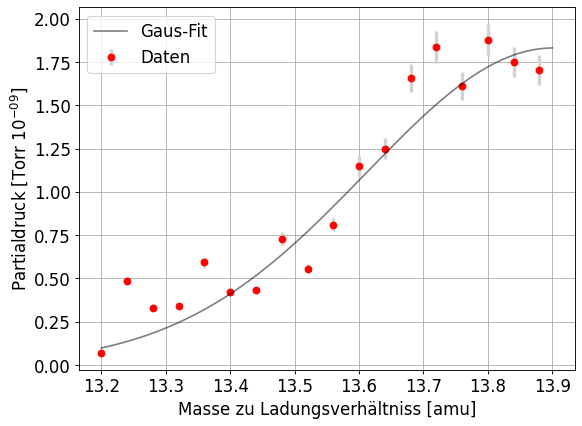

In [6]:
p13 = gaus1fit(13.2,13.9,'uluft_13.6',1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 16
    # variables        = 3
    chi-square         = 709.717420
    reduced chi-square = 54.5936477
    Akaike info crit   = 66.6764507
    Bayesian info crit = 68.9942169
[[Variables]]
    amplitude:  1.8278e-09 +/- 1.9040e-10 (10.42%) (init = 2.632457e-09)
    center:     14.1875792 +/- 0.01699675 (0.12%) (init = 14.2)
    sigma:      0.13850973 +/- 0.00867852 (6.27%) (init = 0.2)
    fwhm:       0.32616549 +/- 0.02043636 (6.27%) == '2.3548200*sigma'
    height:     5.2645e-09 +/- 6.7095e-10 (12.74%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)    = -0.777
    C(amplitude, sigma) = -0.112


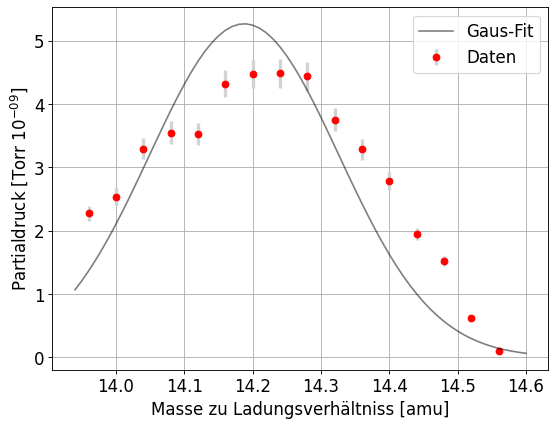

In [7]:
p14 = gaus1fit(13.94,14.6,'uluft_14.2',1e9)#,override=True,m1=14.2,m1min=14,m1max=14.4,m2=13.7,m2min=13.6,m2max=14)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 17
    # variables        = 3
    chi-square         = 254.334858
    reduced chi-square = 18.1667756
    Akaike info crit   = 51.9924527
    Bayesian info crit = 54.4920927
[[Variables]]
    amplitude:  1.0378e-09 +/- 5.6775e-11 (5.47%) (init = 1.309674e-09)
    center:     16.2026167 +/- 0.01117191 (0.07%) (init = 16.23636)
    sigma:      0.18532658 +/- 0.01076244 (5.81%) (init = 0.22)
    fwhm:       0.43641075 +/- 0.02534361 (5.81%) == '2.3548200*sigma'
    height:     2.2340e-09 +/- 1.8052e-10 (8.08%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.511
    C(amplitude, center) = -0.124


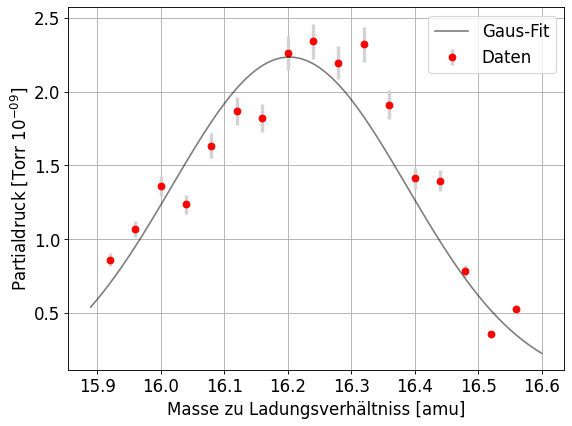

In [8]:
p16 = gaus1fit(15.89,16.6,'uluft_16.2',1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 17
    # variables        = 3
    chi-square         = 1935.02059
    reduced chi-square = 138.215756
    Akaike info crit   = 86.4892183
    Bayesian info crit = 88.9888583
[[Variables]]
    amplitude:  2.4765e-10 +/- 5.1715e-11 (20.88%) (init = 5.773545e-10)
    center:     17.3308640 +/- 0.02488669 (0.14%) (init = 17.31111)
    sigma:      0.12131434 +/- 0.02071631 (17.08%) (init = 0.18)
    fwhm:       0.28567344 +/- 0.04878317 (17.08%) == '2.3548200*sigma'
    height:     8.1439e-10 +/- 2.2655e-10 (27.82%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma) = 0.198


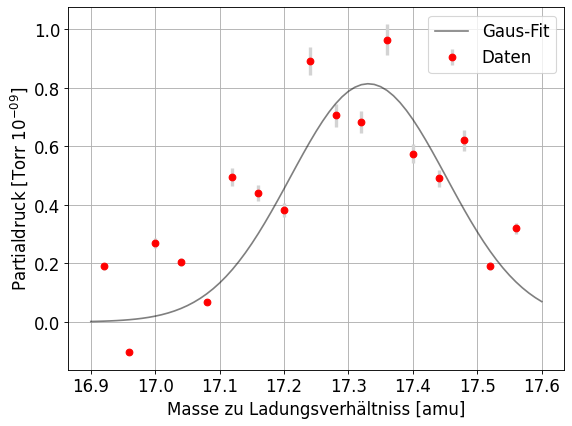

In [9]:
p17 = gaus1fit(16.9,17.6,'uluft_17.2',1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 30
    # variables        = 3
    chi-square         = 3988.20244
    reduced chi-square = 147.711201
    Akaike info crit   = 152.696955
    Bayesian info crit = 156.900547
[[Variables]]
    amplitude:  4.7246e-10 +/- 1.1150e-10 (23.60%) (init = 6.883756e-10)
    center:     18.2477372 +/- 0.02582878 (0.14%) (init = 18.28)
    sigma:      0.11504482 +/- 0.01567691 (13.63%) (init = 0.12)
    fwhm:       0.27090984 +/- 0.03691631 (13.63%) == '2.3548200*sigma'
    height:     1.6384e-09 +/- 4.7265e-10 (28.85%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.264
    C(amplitude, center) = 0.192
    C(amplitude, sigma)  = -0.139


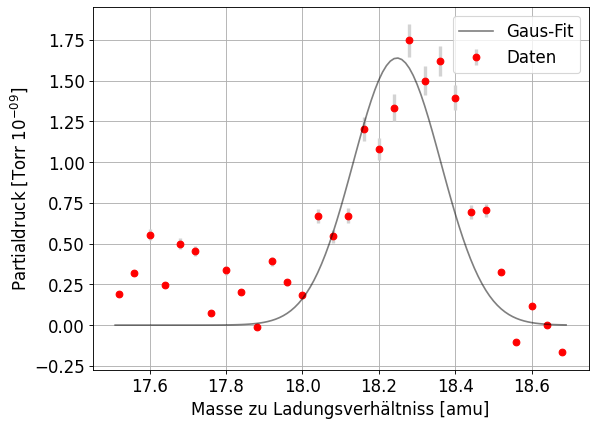

In [10]:
p18 = gaus1fit(17.51,18.7,'uluft_18.2',1e9)#,override=True,m1=18.21,m1min=18,m1max=18.5,s1=0.23,scale1=2.533068e-08,m2=17.21,m2min=17,m2max=17.5,s2=0.9,scale2=7.599203e-09)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 12
    # variables        = 3
    chi-square         = 14.7704995
    reduced chi-square = 1.64116661
    Akaike info crit   = 8.49270319
    Bayesian info crit = 9.94742314
[[Variables]]
    amplitude:  1.4425e-08 +/- 1.2129e-09 (8.41%) (init = 6.089108e-09)
    center:     27.7127522 +/- 0.02440279 (0.09%) (init = 27.64)
    sigma:      0.24705900 +/- 0.01689798 (6.84%) (init = 0.12)
    fwhm:       0.58177947 +/- 0.03979169 (6.84%) == '2.3548200*sigma'
    height:     2.3293e-08 +/- 7.3546e-10 (3.16%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = 0.974
    C(center, sigma)     = 0.941
    C(amplitude, sigma)  = 0.935


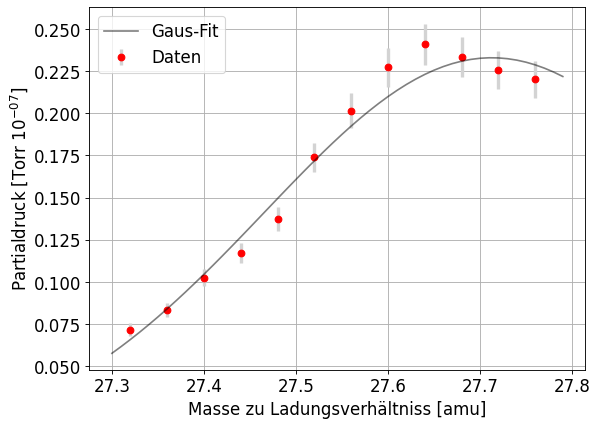

In [11]:
p27 = gaus1fit(27.3,27.8,'uluft_27.75',1e7)#,override=True,m1=28.3,m1min=28,m1max=28.4,m2=27.6,m2min=27.5,m2max=27.8)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 13
    # variables        = 3
    chi-square         = 336.592263
    reduced chi-square = 33.6592263
    Akaike info crit   = 48.3009982
    Bayesian info crit = 49.9958463
[[Variables]]
    amplitude:  4.3365e-08 +/- 3.8097e-09 (8.79%) (init = 5.722297e-08)
    center:     28.2810106 +/- 0.01165140 (0.04%) (init = 28.3)
    sigma:      0.11960713 +/- 0.00754700 (6.31%) (init = 0.14)
    fwhm:       0.28165327 +/- 0.01777182 (6.31%) == '2.3548200*sigma'
    height:     1.4464e-07 +/- 1.7075e-08 (11.80%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)    = -0.722
    C(amplitude, sigma) = -0.202


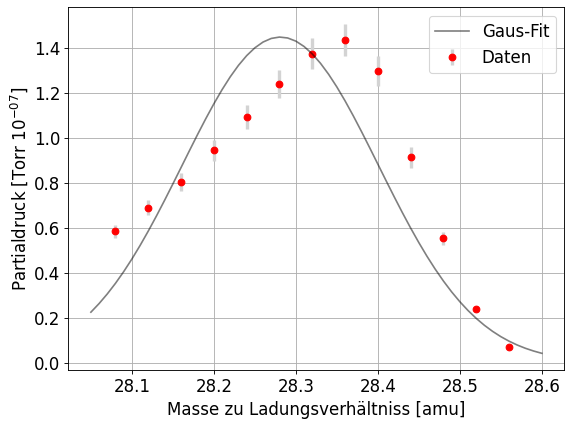

In [12]:
p28 = gaus1fit(28.05,28.6,'uluft_28.2',1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 18
    # variables        = 3
    chi-square         = 251.184384
    reduced chi-square = 16.7456256
    Akaike info crit   = 53.4446792
    Bayesian info crit = 56.1157945
[[Variables]]
    amplitude:  2.2579e-09 +/- 2.6973e-10 (11.95%) (init = 1.736282e-09)
    center:     29.3473137 +/- 0.04437579 (0.15%) (init = 29.28)
    sigma:      0.28586762 +/- 0.03126601 (10.94%) (init = 0.16)
    fwhm:       0.67316678 +/- 0.07362582 (10.94%) == '2.3548200*sigma'
    height:     3.1511e-09 +/- 2.2223e-10 (7.05%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = 0.910
    C(center, sigma)     = 0.895
    C(amplitude, sigma)  = 0.814


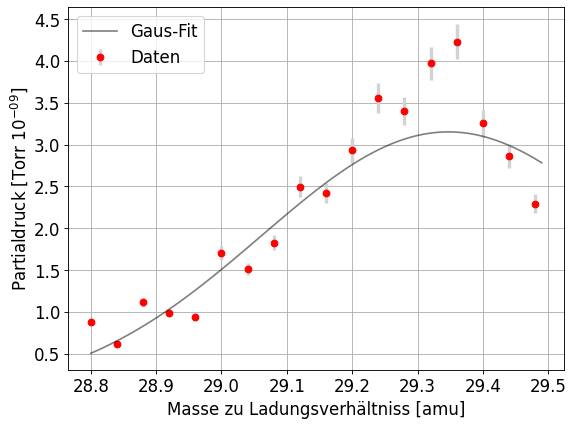

In [13]:
p29 = gaus1fit(28.8,29.5,'uluft_29.2',1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 15
    # variables        = 3
    chi-square         = 291.597210
    reduced chi-square = 24.2997675
    Akaike info crit   = 50.5098485
    Bayesian info crit = 52.6339991
[[Variables]]
    amplitude:  2.9904e-09 +/- 2.0465e-10 (6.84%) (init = 3.302567e-09)
    center:     30.2455945 +/- 0.01017109 (0.03%) (init = 30.26)
    sigma:      0.14251639 +/- 0.00746407 (5.24%) (init = 0.14)
    fwhm:       0.33560044 +/- 0.01757653 (5.24%) == '2.3548200*sigma'
    height:     8.3708e-09 +/- 7.9376e-10 (9.48%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)    = -0.642
    C(amplitude, sigma) = -0.218


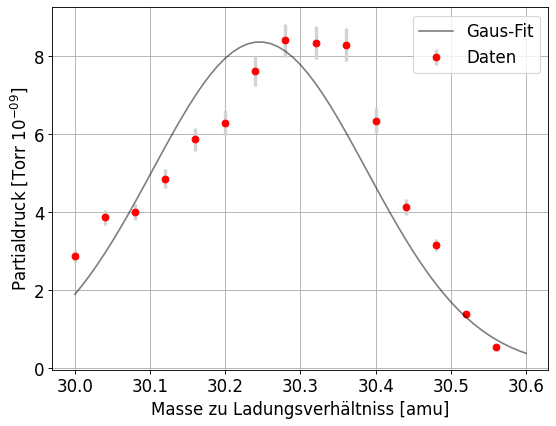

In [14]:
p30 = gaus1fit(30,30.6,'uluft_30.2',1e9)

In [15]:
p31 = gaus1fit(30.8,31.8,'uluft_31.2')

TypeError: gaus1fit() missing 1 required positional argument: 'yscale'

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 20
    # variables        = 3
    chi-square         = 1.1959e-16
    reduced chi-square = 7.0347e-18
    Akaike info crit   = -787.163994
    Bayesian info crit = -784.176797
[[Variables]]
    amplitude:  9.9325e-09 +/- 5.1689e-10 (5.20%) (init = 1.13738e-08)
    center:     32.2282235 +/- 0.01011052 (0.03%) (init = 32.24)
    sigma:      0.17044814 +/- 0.01049544 (6.16%) (init = 0.16)
    fwhm:       0.40137469 +/- 0.02471487 (6.16%) == '2.3548200*sigma'
    height:     2.3248e-08 +/- 1.1947e-09 (5.14%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.602


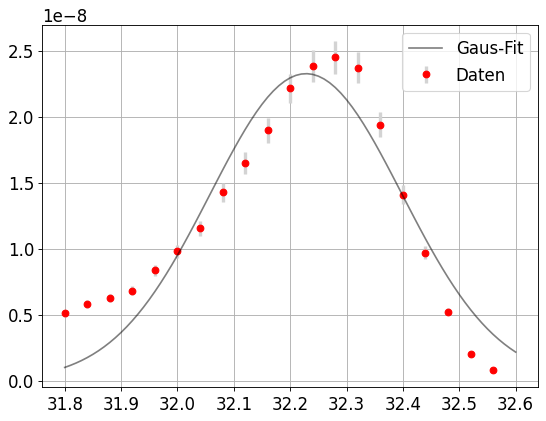

In [ ]:
p32 = gaus1fit(31.8,32.6,'uluft_32.2')

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 27
    # variables        = 3
    chi-square         = 2.9042e-18
    reduced chi-square = 1.2101e-19
    Akaike info crit   = -1173.25777
    Bayesian info crit = -1169.37026
[[Variables]]
    amplitude:  8.4634e-10 +/- 9.0487e-11 (10.69%) (init = 2.524963e-09)
    center:     40.0939868 +/- 0.03272377 (0.08%) (init = 40.06286)
    sigma:      0.27518656 +/- 0.03603908 (13.10%) (init = 0.44)
    fwhm:       0.64801482 +/- 0.08486554 (13.10%) == '2.3548200*sigma'
    height:     1.2270e-09 +/- 1.2545e-10 (10.22%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.647


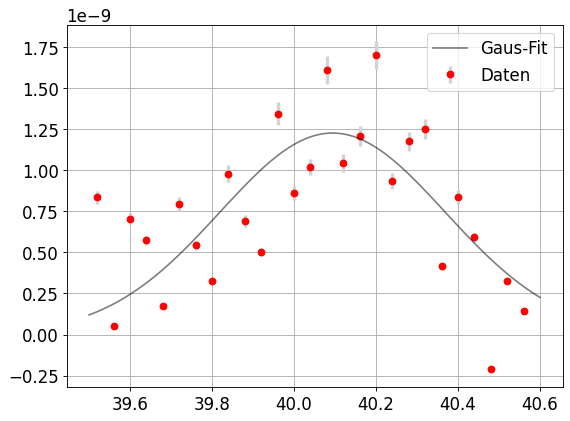

In [ ]:
p40 = gaus1fit(39.5,40.6,'uluft_40.2')

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 50
    # variables        = 3
    chi-square         = 7.5538e-18
    reduced chi-square = 1.6072e-19
    Akaike info crit   = -2160.82488
    Bayesian info crit = -2155.08881
[[Variables]]
    amplitude:  1.1443e-09 +/- 1.3568e-10 (11.86%) (init = 5.119503e-09)
    center:     44.0378698 +/- 0.06496354 (0.15%) (init = 44.0087)
    sigma:      0.48789868 +/- 0.06994595 (14.34%) (init = 0.92)
    fwhm:       1.14891358 +/- 0.16471013 (14.34%) == '2.3548200*sigma'
    height:     9.3569e-10 +/- 1.0785e-10 (11.53%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.627


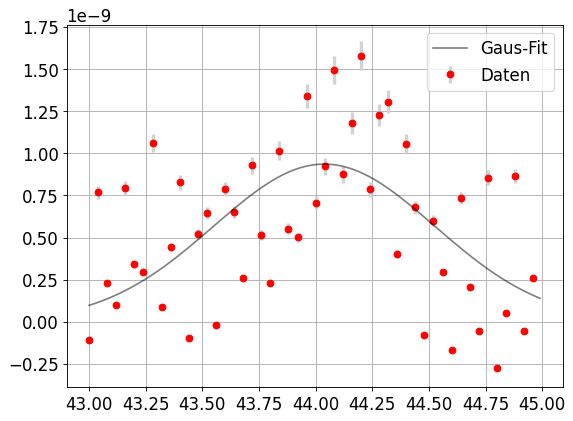

In [ ]:
p44 = gaus1fit(43,45,'uluft_44.2')

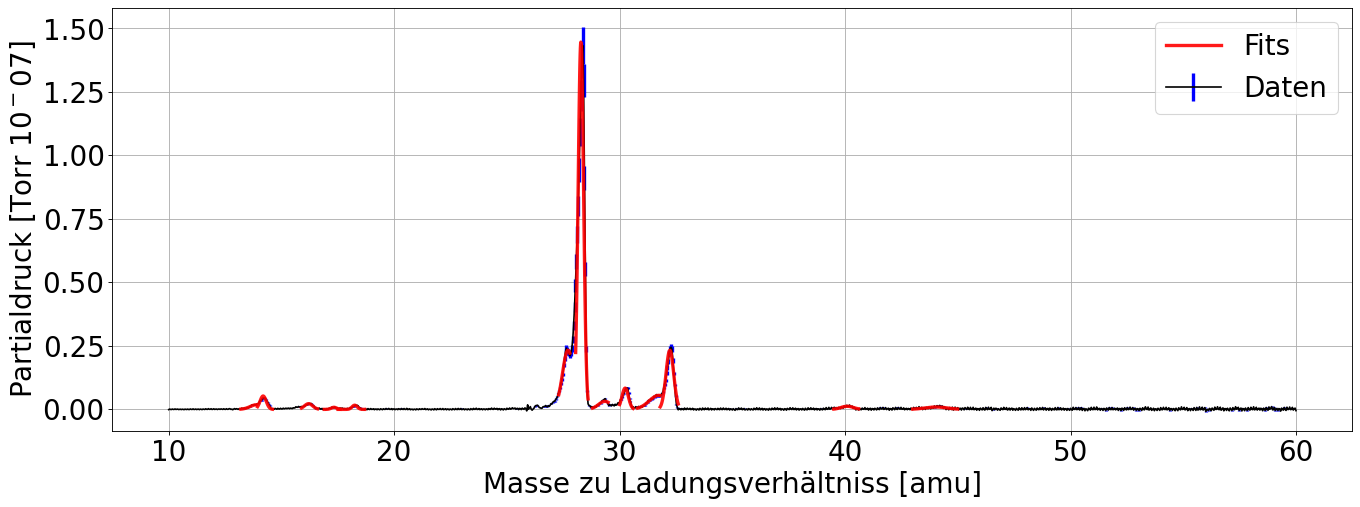

In [ ]:
fig = plt.figure(figsize=(20,7),dpi=80,linewidth=50)
yscale = 1e7
plt.rc ('font', size =25) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 25) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 25) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 25) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 25) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 25) #Schriftgröße der Legende

plt.errorbar(data[0],yscale*data[1],yerr=yscale*data[2],zorder=5,mfc='black',color='k',linestyle='-',label='Daten',ecolor='b',elinewidth=3)

plt.plot(p13[0][0],yscale*p13[0][1],zorder=10,color='r',alpha=0.9,linewidth=3,label='Fits')
plt.plot(p14[0][0],yscale*p14[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p16[0][0],yscale*p16[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p17[0][0],yscale*p17[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p18[0][0],yscale*p18[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p27[0][0],yscale*p27[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p28[0][0],yscale*p28[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p29[0][0],yscale*p29[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p30[0][0],yscale*p30[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p31[0][0],yscale*p31[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p32[0][0],yscale*p32[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p40[0][0],yscale*p40[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p44[0][0],yscale*p44[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)

plt.xlabel('Masse zu Ladungsverhältniss [amu]')
plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
plt.grid()

plt.legend()

In [ ]:

amp12 = ufloat(p13[1].params['amplitude'].value,p13[1].params['amplitude'].stderr)
amp14 = ufloat(p14[1].params['amplitude'].value,p14[1].params['amplitude'].stderr)
amp16 = ufloat(p16[1].params['amplitude'].value,p16[1].params['amplitude'].stderr)
amp17 = ufloat(p17[1].params['amplitude'].value,p17[1].params['amplitude'].stderr)
amp18 = ufloat(p18[1].params['amplitude'].value,p18[1].params['amplitude'].stderr)
amp27 = ufloat(p27[1].params['amplitude'].value,p27[1].params['amplitude'].stderr)
amp28 = ufloat(p28[1].params['amplitude'].value,p28[1].params['amplitude'].stderr)
amp29 = ufloat(p29[1].params['amplitude'].value,p29[1].params['amplitude'].stderr)
amp30 = ufloat(p30[1].params['amplitude'].value,p30[1].params['amplitude'].stderr)
amp31 = ufloat(p31[1].params['amplitude'].value,p31[1].params['amplitude'].stderr)
amp32 = ufloat(p32[1].params['amplitude'].value,p32[1].params['amplitude'].stderr)
amp40 = ufloat(p40[1].params['amplitude'].value,p40[1].params['amplitude'].stderr)
amp44 = ufloat(p44[1].params['amplitude'].value,p44[1].params['amplitude'].stderr)

print('Poesitionm m/z')
print(ufloat(p13[1].params['center'].value,p13[1].params['center'].stderr))
print(ufloat(p14[1].params['center'].value,p14[1].params['center'].stderr))
print(ufloat(p16[1].params['center'].value,p16[1].params['center'].stderr))
print(ufloat(p17[1].params['center'].value,p17[1].params['center'].stderr))
print(ufloat(p18[1].params['center'].value,p18[1].params['center'].stderr))
print(ufloat(p27[1].params['center'].value,p27[1].params['center'].stderr))
print(ufloat(p28[1].params['center'].value,p28[1].params['center'].stderr))
print(ufloat(p29[1].params['center'].value,p29[1].params['center'].stderr))
print(ufloat(p30[1].params['center'].value,p30[1].params['center'].stderr))
print(ufloat(p31[1].params['center'].value,p31[1].params['center'].stderr))
print(ufloat(p32[1].params['center'].value,p32[1].params['center'].stderr))
print(ufloat(p40[1].params['center'].value,p40[1].params['center'].stderr))
print(ufloat(p44[1].params['center'].value,p44[1].params['center'].stderr))



print('Amplitudes')
print(amp12)
print(amp14)
print(amp16)
print(amp17)
print(amp18)
print(amp27)
print(amp28)
print(amp29)
print(amp30)
print(amp31)
print(amp32)
print(amp40)
print(amp44)



print('unkorr amplitude summe hauptpeaks')
print(amp16+amp17+amp18+amp28+amp31+amp32+amp40+amp44)


print('Reihenfolge')
print('Methan')
print('Ammoniak')
print('Wasser')
print('Stickstoff')
print('Ethanol')
print('Sauerstoff')
print('Argon')
print('CO2')



print('Gesamtamplitude')
amp16 = amp16*2.14/1.6
amp17 = amp17*1.9/1.3
amp18 = amp18*1.25/0.9
amp28 = amp28*1.8/1
amp31 = amp31*2.05/3.6
amp32 = amp32*1.11/0.86
amp40 = amp40*1.11/1.2
amp44 = amp44*1.38/1.4

print(amp16)
print(amp17)
print(amp18)
print(amp28)
print(amp31)
print(amp32)
print(amp40)
print(amp44)


sum=amp16+amp17+amp18+amp28+amp31+amp32+amp40+amp44



print('Gesamtdruck')
print(sum)



print('Gesamtdruck speck aufaddiert')
sumgs = 0
for i in range(len(data[1])):
    sumgs += ufloat(data[1,i],data[2,i])
print(sumgs)


print('Gesamtdruck/Gesamtamplituden')
print((amp16*2.14/1.6)/sum)
print((amp17*1.9/1.3)/sum)
print((amp18*1.25/0.9)/sum)
print((amp28*1.8/1)/sum)
print((amp31*2.05/3.6)/sum)
print((amp32*1.11/0.86)/sum)
print((amp40*1.11/1.2)/sum)
print((amp44*1.38/1.4)/sum)


Poesitionm m/z
13.87+/-0.06
14.197+/-0.008
16.201+/-0.018
17.319+/-0.018
18.286+/-0.013
27.75+/-0.06
28.310+/-0.006
29.314+/-0.019
30.258+/-0.015
31.74+/-0.04
32.228+/-0.010
40.094+/-0.033
44.04+/-0.06
Amplitudes
(1.30+/-0.25)e-09
(2.16+/-0.08)e-09
(1.27+/-0.09)e-09
(3.08+/-0.31)e-10
(5.7+/-0.5)e-10
(4.46+/-0.32)e-08
(4.46+/-0.32)e-08
(2.08+/-0.16)e-09
(3.52+/-0.26)e-09
(5.9+/-0.5)e-09
(9.9+/-0.5)e-09
(8.5+/-0.9)e-10
(1.14+/-0.14)e-09
unkorr amplitude summe hauptpeaks
(6.47+/-0.33)e-08
Reihenfolge
Methan
Ammoniak
Wasser
Stickstoff
Ethanol
Sauerstoff
Argon
CO2
Gesamtamplitude
(1.70+/-0.12)e-09
(4.5+/-0.5)e-10
(7.9+/-0.6)e-10
(8.0+/-0.6)e-08
(3.39+/-0.30)e-09
(1.28+/-0.07)e-08
(7.8+/-0.8)e-10
(1.13+/-0.13)e-09
Gesamtdruck
(1.01+/-0.06)e-07
Gesamtdruck speck aufaddiert
(2.365+/-0.018)e-06
Gesamtdruck/Gesamtamplituden
0.0224+/-0.0020
0.0065+/-0.0008
0.0108+/-0.0010
1.426+/-0.024
0.0190+/-0.0020
0.163+/-0.012
0.0071+/-0.0009
0.0110+/-0.0014
